In [15]:
import argparse
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
import cv2

from modules.target_person_detection import target_person_detection
from modules.crop_target_box import crop_target_box
from modules.gesture_recognition import gesture_recognition
from modules.gesture_synthesis import gesture_synthesis
from prep.select_device import select_device
from prep.load_model import load_targets_model, load_gestures_model
from prep.LoadImages import LoadImages
from prep.inference_prep import img_prep, warmup
from prep.time_synch import time_synchronized
from prep.plots import plot_one_box

def main(opt):
    target, img_source, show_plots, save = opt.target, opt.img_source, opt.show_plots, opt.save
    results = {}
    speed = []
    
    # Initialize
    device = select_device('0')
    half = device.type != 'cpu' 
    
    # Load all models and prep everything that I'll need for inference
    targets_model, stride = load_targets_model(target, device, half)
    gestures_model, stride_g = load_gestures_model(device, half)
    
    # Load DataLoader
    dataset = LoadImages(img_source, img_size=1024, stride=stride)
    print(dataset)
    
    # Prep for warmup
    old_img_w = old_img_h = 1024
    old_img_b = 1
    
    # Initialize plot
    num_columns = 3
    num_rows = (dataset.nf + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns * 2, figsize=(15, 5 * num_rows))
    plt.subplots_adjust(hspace=0.5)
    axes = axes.flatten()
    index = 0
    
    for path, img, im0s in tqdm(dataset):
        img = img_prep(img, device, half)
        warmup(targets_model, device, old_img_b, old_img_h, old_img_w, img)
        
        # Start timer
        t1 = time_synchronized()

        # Detect target person on imgs
        person_bboxs = target_person_detection(targets_model, path, img, im0s, opt.conf_thres)
        
        # Extract
        person_extracted_img, xyxy = crop_target_box(person_bboxs, im0s)
        
        if isinstance(person_extracted_img, int) and person_extracted_img == -1:
            p = -1
            
        else:
            # Detect gestures
            img = img_prep(person_extracted_img, device, half, cropped_img=True, stride=stride_g)
            gestures_preds = gesture_recognition(gestures_model, path, img, person_extracted_img, opt.conf_thres)
            
            # Classify
            p = gesture_synthesis(gestures_preds)
        
        # Stop timer & save results
        t2 = time_synchronized()
        full_time = 1E3 * (t2 - t1)
        speed.append(full_time)
        results[os.path.basename(path)] = int(p)
        
        # Prep subplot
        plot_one_box(xyxy, im0s, color=[0, 255, 0], label='target', line_thickness=3)
        for gesture_pred in gestures_preds:
            plot_one_box(gesture_pred[0:4], person_extracted_img, color=[0, 0, 255], label=str(gesture_pred[5]), line_thickness=3)

        ax1 = axes[index * 2]
        ax1.imshow(cv2.cvtColor(im0s, cv2.COLOR_BGR2RGB))
        ax1.set_title(os.path.basename(path))
        ax1.axis('off')

        ax2 = axes[index * 2 + 1]
        ax2.imshow(cv2.cvtColor(person_extracted_img, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'p={int(p)}')
        ax2.axis('off')

        index += 1
        
        
    # Print final results
    print(results)
    print(speed)
    print(f"average time: {(sum(speed) / len(speed)):.1f}ms")
    
    for i in range(index * 2, len(axes)):
        axes[i].axis('off')

    plt.show()

In [16]:
%matplotlib inline

Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse


10it [00:03,  2.70it/s]


{'075823f53f.jpg': 0, '185fcae3be.jpg': 2, '236ba0daed.jpg': 0, '2b70b73c73.jpg': 4, '474d3ae1fe.jpg': 0, '4a8512a9e3.jpg': 0, '523fe5470b.jpg': 4, '5cc8062e8e.jpg': 0, '62f5f46069.jpg': 0, '7a1caec0a6.jpg': 1}
[47.727346420288086, 43.46179962158203, 50.23360252380371, 82.47518539428711, 49.51786994934082, 47.38974571228027, 39.66569900512695, 46.39458656311035, 40.14253616333008, 69.62251663208008]
average time: 51.7ms


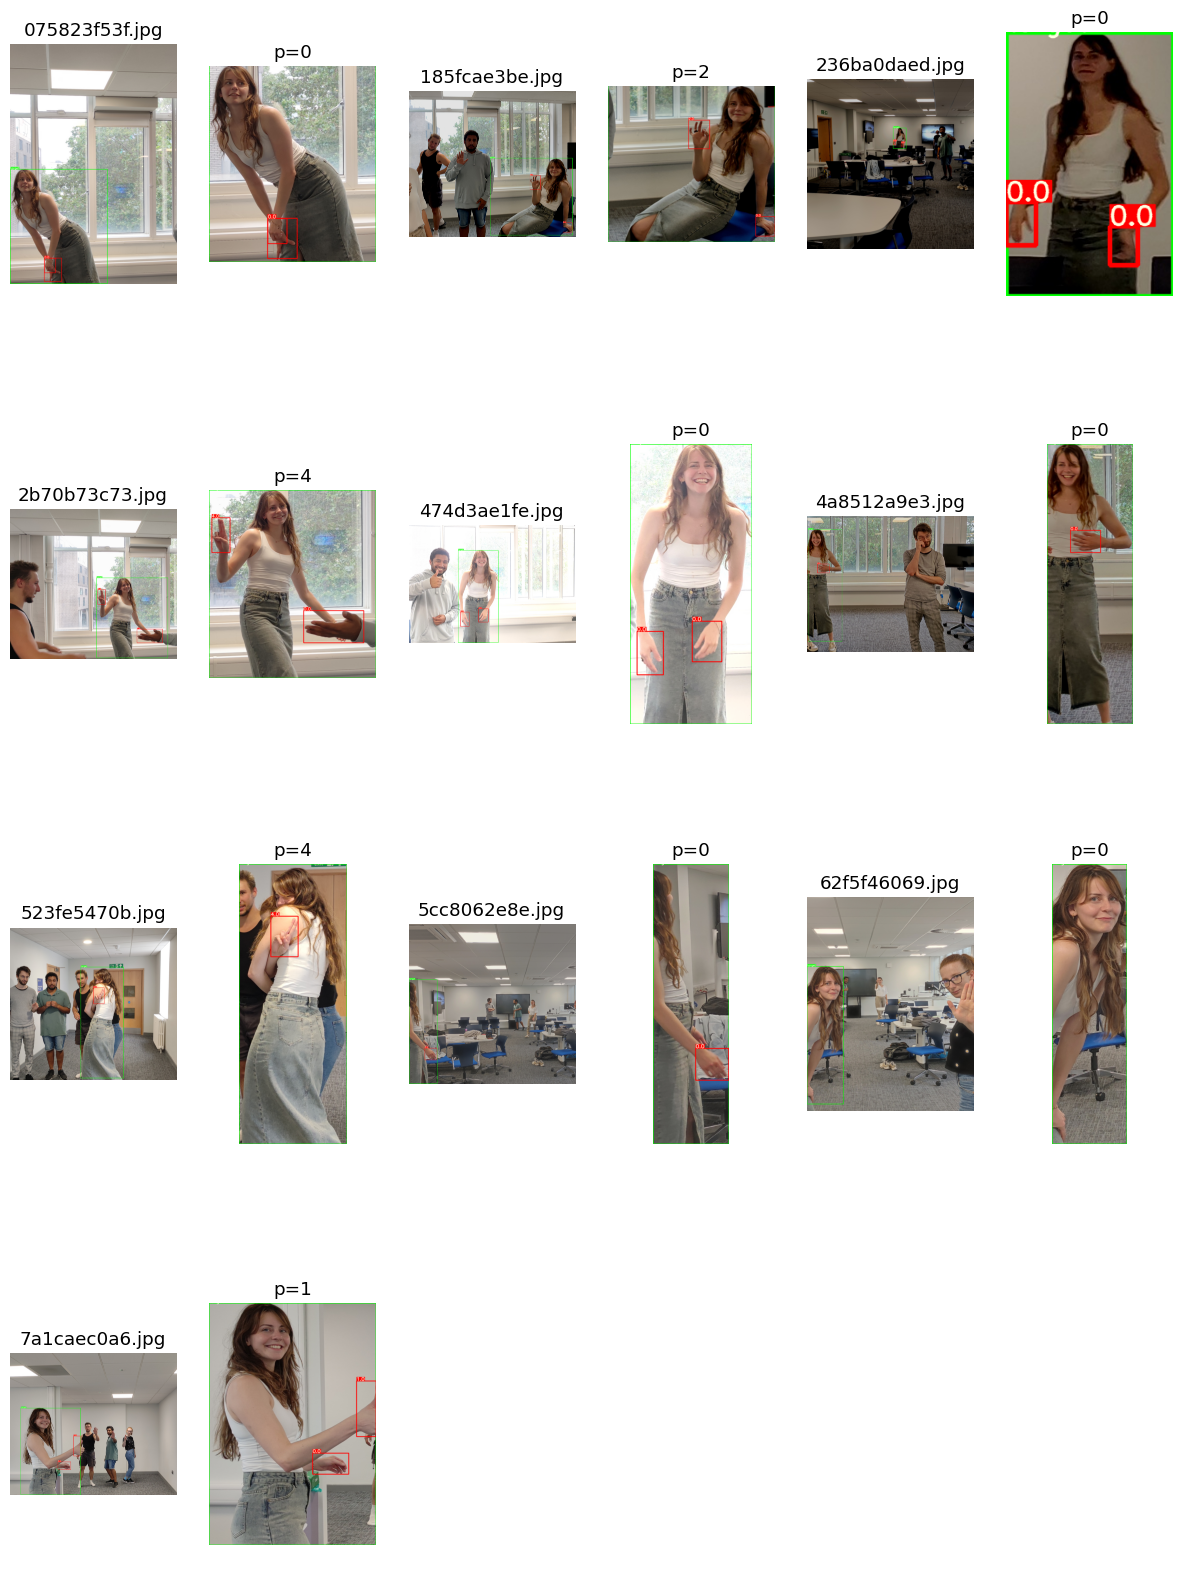

In [17]:
import argparse

opt = argparse.Namespace(
    target=0,
    img_source="./../datasets/SIGGI/full/0_small",
    conf_thres=0.231,
    show_plots=False,
    save=False
)

main(opt)